# Not Interactive

In [ ]:
"""IMPORTS"""
from astropy import units as u
from astropy.coordinates import EarthLocation,SkyCoord
from astroquery.irsa_dust import IrsaDust
import astropy.units as u
from astroquery.skyview import SkyView

from astropy.io import fits as pyfits
import glob
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
%matplotlib inline
#!pip install aplpy
import aplpy
import numpy as np
import os

from datetime import datetime,timedelta
from astroplan import Observer
from astroplan import FixedTarget
from astroplan.plots import plot_airmass
#from astroplan import download_IERS_A
#download_IERS_A()

import matplotlib.patches as patches
import matplotlib


"""Parameters"""
now = datetime.now()
tomorrow=datetime.now() + timedelta(days=1)
"""ra=?????????
dec=?????????
name=?????????"""


def Galactic_lat_long(ra,dec):
    lb=SkyCoord('%s %s'%(ra, dec), unit=(u.hourangle,u.deg))
    l = lb.galactic.l
    b = lb.galactic.b
    return l,b

def dust_maps(ra, dec):
    """Input args are Right Ascension (RA) and Declination(DEC) and must be in format [e.g: -29 51 56.74]"""
    dust_map = IrsaDust.get_images("%s %s" %(ra, dec), image_type="ebv", radius=5 * u.deg)
    dust=[]
    for f in dust_map:
        dust.append(np.array((f)[0].data, dtype=float))
    return dust


def optical_image(ra, dec):
    """Input args are Right Ascension (RA) and Declination(DEC) and must be in format [e.g: -29 51 56.74]"""
    path = SkyView.get_images(position="%s %s" %(ra, dec), survey=['DSS'], radius=2.6 * u.deg)
    optical=[]
    for f in path:
        optical.append(np.array((f)[0].data, dtype=float))
    return optical

def coloured_optical_image(ra, dec):
    """Input args are Right Ascension (RA) and Declination(DEC) and must be in format [e.g: -29 51 56.74]"""
    pathr = SkyView.get_images(position="%s %s" %(ra, dec), survey=['DSS1 Red'], radius=0.2 * u.deg)#can decrease radius to zoom in coloured picture
    opticalr=[]
    for f in pathr:
        opticalr.append(np.array((f)[0].data, dtype=float))
    pyfits.writeto("pathr.fit",opticalr[0],clobber=True)

    pathb = SkyView.get_images(position="%s %s" %(ra, dec), survey=['DSS1 Blue'], radius=0.2 * u.deg)
    opticalb=[]
    for f in pathb:
        opticalb.append(np.array((f)[0].data, dtype=float))
    pyfits.writeto("pathb.fit",opticalb[0],clobber=True)

    pathIR = SkyView.get_images(position="%s %s" %(ra, dec), survey=['DSS2 IR'], radius=0.2 * u.deg)
    opticalIR=[]
    for f in pathIR:
        opticalIR.append(np.array((f)[0].data, dtype=float))
    pyfits.writeto("pathIR.fit",opticalIR[0],clobber=True)
    
    """Saving coloured Image"""
    aplpy.make_rgb_image(['pathIR.fit','pathr.fit','pathb.fit'], 'RGB.png')



def air_mass_plot(now, tomorrow, ra, dec):
    """Input args are time now and tomorrow and are automatically calculated in 'Parameters' listings, as well as Input args of Right Ascension (RA) and Declination(DEC) which must be in format [e.g: -29 51 56.74]"""
    delta_t = tomorrow - now
    observe_time = now + delta_t*np.linspace(0, 1, 75)
    '''Parameters-Location'''
    longitude = 149.06119444444445 * u.deg
    latitude = -31.273361111111114 * u.deg
    elevation = 1149.000000001551  * u.m
    location = EarthLocation.from_geodetic(longitude, latitude, elevation)
    observer = Observer(name='Siding Spring Observatory',location=location)
    coordinates = SkyCoord('%s %s'%(ra, dec), unit=(u.hourangle,u.deg), frame='icrs')
    target = FixedTarget(name='Target', coord=coordinates)
    '''Plot'''
    plot_airmass(target, observer, observe_time, brightness_shading=True, altitude_yaxis=True).set_title('Air Mass (RA %s-DEC %s)'%(ra,dec))
    plt.tight_layout()
    plt.savefig('RA %s-DEC %s_AM.png'%(ra,dec))
    #plt.show()



def all_information_image(ra, dec, l, b, dust, optical, name):
    """ra&dec in format [e.g: -29 51 56.74], dust&optical are from above results, name is included if given"""
    fig = plt.figure(figsize=(8,2.7))
    #Coloured Image
    ax1 = fig.add_axes([0,0,0.337,1])
    plt.imshow(mpimg.imread('RGB.png'),cmap='gray')
    ax1.axes.get_xaxis().set_ticks([])
    ax1.axes.get_yaxis().set_ticks([])
    plt.plot([0.02,0.02+(0.20)],[0.12,0.12+(1)],marker=None,color='red',linewidth=0.1)
    plt.text(45,22,"OPTICAL IMAGE (B,R,IR)", color='gold', fontweight='bold')
    ax1.add_patch(patches.Rectangle((3, 3),294,294,fill=False,edgecolor="red", linewidth=3))
    for child in ax1.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('red')
            child.set_lw(3)
    #Dust Map
    ax2 = fig.add_axes([0.337,0,0.337,1])
    plt.imshow(dust[0],cmap='magma')
    ax2.axes.get_xaxis().set_ticks([])
    ax2.axes.get_yaxis().set_ticks([])
    plt.plot([0.19,0.19+(0.20-0.03)],[0.12,0.12+(1-0.24)],marker=None,linewidth=1)
    plt.text(32,13,"GALACTIC DUST IMAGE", color='gold',fontweight='bold')
    plt.text(43,42,"Huntsman Field Of View", color='#0000ff', size=9)
    plt.text(80,88,"OI (B,R,IR)", color='red', size=8)
    ax2.add_patch(patches.Rectangle((45, 45),109,109,fill=False,edgecolor="#0000ff"))
    ax2.add_patch(patches.Rectangle((93,90.5),18,18,fill=False,edgecolor="red"))
    for child in ax2.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('None')
            child.set_lw(2)
    ##Other Text
    plt.text(210,20,"%s"%(name),size=13, fontweight='bold')
    plt.text(210,45,"RA:  %s"%(ra), size=10)
    plt.text(210,70,"DEC:  %s"%(dec), size=10)
    plt.text(210,100,"Galactic Coordinates", size=10, fontweight='bold')
    plt.text(210,115,"l: %s"%(l), size=10)
    plt.text(210,130,"b: %s"%(b), size=10)
    plt.text(210,155,"DUST", size=10, fontweight='bold')
    plt.text(210,170,"SD: %s E(B-V)"%(round(np.std(dust),4)), size=9)
    plt.text(210,185,"Mean: %s E(B-V)"%(round(np.mean(dust), 4)), size=9)
    ##changing Colorbar
    colour=plt.colorbar(cax=plt.axes([0.355, 0.1,0.3,0.06]),orientation="horizontal",ticks=np.linspace((round(np.min(dust),2)),(round(np.max(dust),2)), 5, endpoint=False))
    plt.setp(plt.getp(colour.ax.axes, 'xticklabels'), color='w', size=9)   
    colour.ax.xaxis.set_tick_params(color='w')
    #Optical
    ax3 = fig.add_axes([0.86,0,0.15,0.38])#x,y,widthx widthy
    plt.imshow(optical,cmap='gray')
    ax3.axes.get_xaxis().set_ticks([])
    ax3.axes.get_yaxis().set_ticks([])
    plt.plot([0.02,0.02+(0.20)],[0.12,0.12+(1)],marker=None,color='red',linewidth=0.1)
    plt.text(17,30,"Hutsman Field", color='gold', fontweight='bold',size = 8)
    for child in ax3.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('#0000ff')
            child.set_lw(2)
    #Logo
    ax4 = fig.add_axes([0.86,0.7,0.15,0.3])
    plt.imshow(mpimg.imread('Logo.png'),cmap='gray')
    ax4.axes.get_xaxis().set_ticks([])
    ax4.axes.get_yaxis().set_ticks([])
    plt.plot([0.02,0.02+(0.20)],[0.12,0.12+(1)],marker=None)
    for child in ax4.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('None')
            child.set_lw(1)
    fig.savefig('RA %s-DEC %s.png'%(ra,dec))
    image=mpimg.imread('RA %s-DEC %s.png'%(ra,dec))
"""plt.imshow(image)
    plt.axis("off")
    plt.show()"""

l,b=Galactic_lat_long(ra, dec)
dust=dust_maps(ra,dec)
optical=optical_image(ra,dec)
bob=coloured_optical_image(ra,dec)
frank=air_mass_plot(now, tomorrow, ra, dec)
all_information_image(ra, dec, l, b, dust, optical[0], name)

# Not Interactive - EXAMPLE

INFO: Red: [aplpy.rgb]
INFO: vmin =  4.144e+03 (auto) [aplpy.rgb]
INFO: vmax =  2.149e+04 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin =  4.449e+03 (auto) [aplpy.rgb]
INFO: vmax =  1.273e+04 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin =  3.877e+03 (auto) [aplpy.rgb]
INFO: vmax =  1.224e+04 (auto) [aplpy.rgb]


C:\Users\Taylah\Anaconda3\lib\site-packages\aplpy\rgb.py:218: UserWarning: PyAVM 0.9.1 or later is not installed, so AVM tags will not be embedded in RGB image
  warnings.warn("PyAVM 0.9.1 or later is not installed, so AVM tags will not be embedded in RGB image")


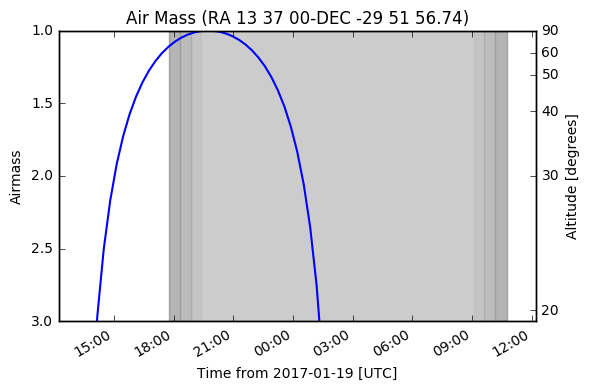

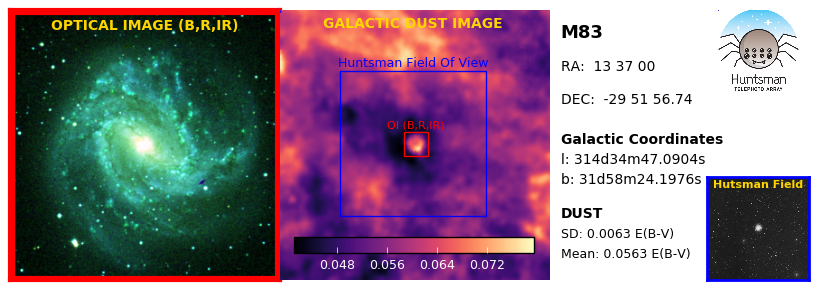

In [1]:
"""IMPORTS"""
from astropy import units as u
from astropy.coordinates import EarthLocation,SkyCoord
from astroquery.irsa_dust import IrsaDust
import astropy.units as u
from astroquery.skyview import SkyView

from astropy.io import fits as pyfits
import glob
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
%matplotlib inline
#!pip install aplpy
import aplpy
import numpy as np
import os

from datetime import datetime,timedelta
from astroplan import Observer
from astroplan import FixedTarget
from astroplan.plots import plot_airmass
#from astroplan import download_IERS_A
#download_IERS_A()

import matplotlib.patches as patches
import matplotlib


"""Parameters"""
now = datetime.now()
tomorrow=datetime.now() + timedelta(days=1)
ra='13 37 00'
dec='-29 51 56.74'
name='M83'


def Galactic_lat_long(ra,dec):
    lb=SkyCoord('%s %s'%(ra, dec), unit=(u.hourangle,u.deg))
    l = lb.galactic.l
    b = lb.galactic.b
    return l,b

def dust_maps(ra, dec):
    """Input args are Right Ascension (RA) and Declination(DEC) and must be in format [e.g: -29 51 56.74]"""
    dust_map = IrsaDust.get_images("%s %s" %(ra, dec), image_type="ebv", radius=5 * u.deg)
    dust=[]
    for f in dust_map:
        dust.append(np.array((f)[0].data, dtype=float))
    return dust


def optical_image(ra, dec):
    """Input args are Right Ascension (RA) and Declination(DEC) and must be in format [e.g: -29 51 56.74]"""
    path = SkyView.get_images(position="%s %s" %(ra, dec), survey=['DSS'], radius=2.6 * u.deg)
    optical=[]
    for f in path:
        optical.append(np.array((f)[0].data, dtype=float))
    return optical

def coloured_optical_image(ra, dec):
    """Input args are Right Ascension (RA) and Declination(DEC) and must be in format [e.g: -29 51 56.74]"""
    pathr = SkyView.get_images(position="%s %s" %(ra, dec), survey=['DSS1 Red'], radius=0.2 * u.deg)#can decrease radius to zoom in coloured picture
    opticalr=[]
    for f in pathr:
        opticalr.append(np.array((f)[0].data, dtype=float))
    pyfits.writeto("pathr.fit",opticalr[0],clobber=True)

    pathb = SkyView.get_images(position="%s %s" %(ra, dec), survey=['DSS1 Blue'], radius=0.2 * u.deg)
    opticalb=[]
    for f in pathb:
        opticalb.append(np.array((f)[0].data, dtype=float))
    pyfits.writeto("pathb.fit",opticalb[0],clobber=True)

    pathIR = SkyView.get_images(position="%s %s" %(ra, dec), survey=['DSS2 IR'], radius=0.2 * u.deg)
    opticalIR=[]
    for f in pathIR:
        opticalIR.append(np.array((f)[0].data, dtype=float))
    pyfits.writeto("pathIR.fit",opticalIR[0],clobber=True)
    
    """Saving coloured Image"""
    aplpy.make_rgb_image(['pathIR.fit','pathr.fit','pathb.fit'], 'RGB.png')



def air_mass_plot(now, tomorrow, ra, dec):
    """Input args are time now and tomorrow and are automatically calculated in 'Parameters' listings, as well as Input args of Right Ascension (RA) and Declination(DEC) which must be in format [e.g: -29 51 56.74]"""
    delta_t = tomorrow - now
    observe_time = now + delta_t*np.linspace(0, 1, 75)
    '''Parameters-Location'''
    longitude = 149.06119444444445 * u.deg
    latitude = -31.273361111111114 * u.deg
    elevation = 1149.000000001551  * u.m
    location = EarthLocation.from_geodetic(longitude, latitude, elevation)
    observer = Observer(name='Siding Spring Observatory',location=location)
    coordinates = SkyCoord('%s %s'%(ra, dec), unit=(u.hourangle,u.deg), frame='icrs')
    target = FixedTarget(name='Target', coord=coordinates)
    '''Plot'''
    plot_airmass(target, observer, observe_time, brightness_shading=True, altitude_yaxis=True).set_title('Air Mass (RA %s-DEC %s)'%(ra,dec))
    plt.tight_layout()
    plt.savefig('RA %s-DEC %s_AM.png'%(ra,dec))
    #plt.show()



def all_information_image(ra, dec, l, b, dust, optical, name):
    """ra&dec in format [e.g: -29 51 56.74], dust&optical are from above results, name is included if given"""
    fig = plt.figure(figsize=(8,2.7))
    #Coloured Image
    ax1 = fig.add_axes([0,0,0.337,1])
    plt.imshow(mpimg.imread('RGB.png'),cmap='gray')
    ax1.axes.get_xaxis().set_ticks([])
    ax1.axes.get_yaxis().set_ticks([])
    plt.plot([0.02,0.02+(0.20)],[0.12,0.12+(1)],marker=None,color='red',linewidth=0.1)
    plt.text(45,22,"OPTICAL IMAGE (B,R,IR)", color='gold', fontweight='bold')
    ax1.add_patch(patches.Rectangle((3, 3),294,294,fill=False,edgecolor="red", linewidth=3))
    for child in ax1.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('red')
            child.set_lw(3)
    #Dust Map
    ax2 = fig.add_axes([0.337,0,0.337,1])
    plt.imshow(dust[0],cmap='magma')
    ax2.axes.get_xaxis().set_ticks([])
    ax2.axes.get_yaxis().set_ticks([])
    plt.plot([0.19,0.19+(0.20-0.03)],[0.12,0.12+(1-0.24)],marker=None,linewidth=1)
    plt.text(32,13,"GALACTIC DUST IMAGE", color='gold',fontweight='bold')
    plt.text(43,42,"Huntsman Field Of View", color='#0000ff', size=9)
    plt.text(80,88,"OI (B,R,IR)", color='red', size=8)
    ax2.add_patch(patches.Rectangle((45, 45),109,109,fill=False,edgecolor="#0000ff"))
    ax2.add_patch(patches.Rectangle((93,90.5),18,18,fill=False,edgecolor="red"))
    for child in ax2.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('None')
            child.set_lw(2)
    ##Other Text
    plt.text(210,20,"%s"%(name),size=13, fontweight='bold')
    plt.text(210,45,"RA:  %s"%(ra), size=10)
    plt.text(210,70,"DEC:  %s"%(dec), size=10)
    plt.text(210,100,"Galactic Coordinates", size=10, fontweight='bold')
    plt.text(210,115,"l: %s"%(l), size=10)
    plt.text(210,130,"b: %s"%(b), size=10)
    plt.text(210,155,"DUST", size=10, fontweight='bold')
    plt.text(210,170,"SD: %s E(B-V)"%(round(np.std(dust),4)), size=9)
    plt.text(210,185,"Mean: %s E(B-V)"%(round(np.mean(dust), 4)), size=9)
    ##changing Colorbar
    colour=plt.colorbar(cax=plt.axes([0.355, 0.1,0.3,0.06]),orientation="horizontal",ticks=np.linspace((round(np.min(dust),2)),(round(np.max(dust),2)), 5, endpoint=False))
    plt.setp(plt.getp(colour.ax.axes, 'xticklabels'), color='w', size=9)   
    colour.ax.xaxis.set_tick_params(color='w')
    #Optical
    ax3 = fig.add_axes([0.86,0,0.15,0.38])#x,y,widthx widthy
    plt.imshow(optical,cmap='gray')
    ax3.axes.get_xaxis().set_ticks([])
    ax3.axes.get_yaxis().set_ticks([])
    plt.plot([0.02,0.02+(0.20)],[0.12,0.12+(1)],marker=None,color='red',linewidth=0.1)
    plt.text(17,30,"Hutsman Field", color='gold', fontweight='bold',size = 8)
    for child in ax3.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('#0000ff')
            child.set_lw(2)
    #Logo
    ax4 = fig.add_axes([0.86,0.7,0.15,0.3])
    plt.imshow(mpimg.imread('Logo.png'),cmap='gray')
    ax4.axes.get_xaxis().set_ticks([])
    ax4.axes.get_yaxis().set_ticks([])
    plt.plot([0.02,0.02+(0.20)],[0.12,0.12+(1)],marker=None)
    for child in ax4.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('None')
            child.set_lw(1)
    fig.savefig('RA %s-DEC %s.png'%(ra,dec))
    image=mpimg.imread('RA %s-DEC %s.png'%(ra,dec))
"""plt.imshow(image)
    plt.axis("off")
    plt.show()"""

l,b=Galactic_lat_long(ra, dec)
dust=dust_maps(ra,dec)
optical=optical_image(ra,dec)
bob=coloured_optical_image(ra,dec)
frank=air_mass_plot(now, tomorrow, ra, dec)
all_information_image(ra, dec, l, b, dust, optical[0], name)

# Interactive

Welcome! Please type in a potential target's RA and Dec (in the form RA:[hh mm ss] and Dec:[°° ′′ ″″]): 
RA -> 13 37 00
Dec -> -29 51 56.74


-------------------------------------------------------------------------
INFO: Red: [aplpy.rgb]
INFO: vmin =  4.144e+03 (auto) [aplpy.rgb]
INFO: vmax =  2.149e+04 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin =  4.449e+03 (auto) [aplpy.rgb]
INFO: vmax =  1.273e+04 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin =  3.877e+03 (auto) [aplpy.rgb]
INFO: vmax =  1.224e+04 (auto) [aplpy.rgb]


C:\Users\Taylah\Anaconda3\lib\site-packages\aplpy\rgb.py:218: UserWarning: PyAVM 0.9.1 or later is not installed, so AVM tags will not be embedded in RGB image
  warnings.warn("PyAVM 0.9.1 or later is not installed, so AVM tags will not be embedded in RGB image")


-------------------------------------------------------------------------



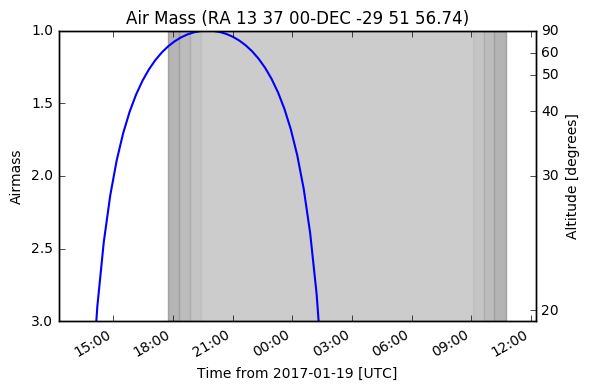


Would you like to save this information?
[y or n] ->  y
Image saved as: "RA:13 37 00-DEC-29 51 56.74.png"


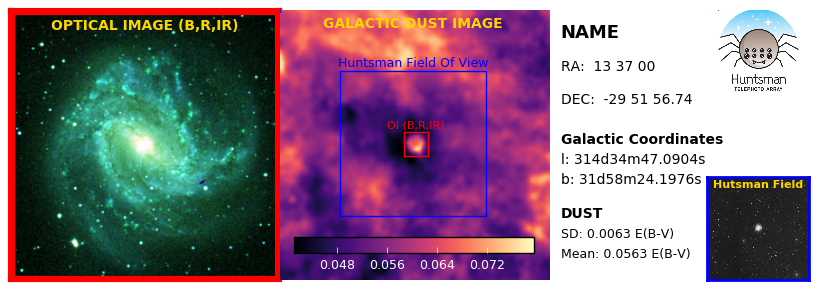

In [2]:
"""IMPORTS"""
from astropy import units as u
from astropy.coordinates import EarthLocation,SkyCoord
from astroquery.irsa_dust import IrsaDust
import astropy.units as u
from astroquery.skyview import SkyView

from astropy.io import fits as pyfits
import glob
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
%matplotlib inline
#!pip install aplpy
import aplpy
import numpy as np
import os

from datetime import datetime,timedelta
from astroplan import Observer
from astroplan import FixedTarget
from astroplan.plots import plot_airmass
#from astroplan import download_IERS_A
#download_IERS_A()

import matplotlib.patches as patches
import matplotlib


"""INPUT"""
'''RA and Dec'''
print ("Welcome! Please type in a potential target's RA and Dec (in the form RA:[hh mm ss] and Dec:[°° ′′ ″″]): ")
RA_DEC = (input("RA -> "),input("Dec -> "))
print()

"""This is the conversion from the inputed RA and Dec into the units of degrees. Then, through the '.galactic', l and b are found"""
lb=SkyCoord('%s %s'%(RA_DEC[0], RA_DEC[1]), unit=(u.hourangle,u.deg))
l_b = lb.galactic


"""Parameters #1"""
ra=RA_DEC[0] #10 18 00
dec=RA_DEC[1]
l=l_b.l #Galactic Lat
b=l_b.b #Galactic Long
now = datetime.now()
tomorrow=datetime.now() + timedelta(days=1)
name='NAME'

"""Dowloading Relevent Images: dust, optical coloured"""
print ()
print ("-------------------------------------------------------------------------")
print ('Downloading Relevant Images: ')

'''DUST'''
dust_map = IrsaDust.get_images("%s %s" %(ra, dec), image_type="ebv", radius=5 * u.deg)
"""creating arrays"""
dust=[]
for f in dust_map:
    dust.append(np.array((f)[0].data, dtype=float))
 
'''OPTICAL IMAGES'''
path = SkyView.get_images(position="%s %s" %(ra, dec), survey=['DSS'], radius=2.6 * u.deg)
"""creating arrays"""
optical=[]
for f in path:
    optical.append(np.array((f)[0].data, dtype=float))

"""Parameters #2"""
dust=dust[0] 
optical=optical[0]


'''COLOURED OPTICAL IMAGE'''
pathr = SkyView.get_images(position="%s %s" %(ra, dec), survey=['DSS1 Red'], radius=0.2 * u.deg)#can decrease radius to zoom in coloured picture
opticalr=[]
for f in pathr:
    opticalr.append(np.array((f)[0].data, dtype=float))
pyfits.writeto("pathr.fit",opticalr[0],clobber=True)

pathb = SkyView.get_images(position="%s %s" %(ra, dec), survey=['DSS1 Blue'], radius=0.2 * u.deg)#can decrease radius to zoom in coloured picture
opticalb=[]
for f in pathb:
    opticalb.append(np.array((f)[0].data, dtype=float))
pyfits.writeto("pathb.fit",opticalb[0],clobber=True)

pathIR = SkyView.get_images(position="%s %s" %(ra, dec), survey=['DSS2 IR'], radius=0.2 * u.deg)#can decrease radius to zoom in coloured picture
opticalIR=[]
for f in pathIR:
    opticalIR.append(np.array((f)[0].data, dtype=float))
pyfits.writeto("pathIR.fit",opticalIR[0],clobber=True)
'''Saving coloured Image'''
aplpy.make_rgb_image(['pathIR.fit','pathr.fit','pathb.fit'], 'RGB.png')
print ("-------------------------------------------------------------------------")
print ()



"""AIR-MASS"""

'''Time'''
start_time = now
end_time = tomorrow
delta_t = end_time - start_time
observe_time = start_time + delta_t*np.linspace(0, 1, 75)
'''Parameters-Location'''
longitude = 149.06119444444445 * u.deg
latitude = -31.273361111111114 * u.deg
elevation = 1149.000000001551  * u.m
location = EarthLocation.from_geodetic(longitude, latitude, elevation)
observer = Observer(name='Siding Spring Observatory',location=location)
coordinates = SkyCoord('%s %s'%(ra, dec), unit=(u.hourangle,u.deg), frame='icrs')
target = FixedTarget(name='Target', coord=coordinates)
'''Plot'''
plot_airmass(target, observer, observe_time, brightness_shading=True, altitude_yaxis=True).set_title('Air Mass (RA %s-DEC %s)'%(ra,dec))
plt.tight_layout()
plt.savefig('RA %s-DEC %s_AM.png'%(ra,dec))
plt.show()

print()



"""SAVED IMAGE :)"""
print ("Would you like to save this information?")
save = input("[y or n] ->  ")

while (save != "y") and (save !="n"):
    print ('Sorry, invalid input')
    save =  input("Would you like to save the information? [y or n] ->  ")
if save =='y':
    print ('Image saved as: \"RA:%s-DEC%s.png\"'%(ra,dec))
    fig = plt.figure(figsize=(8,2.7))
    #Coloured Image
    ax1 = fig.add_axes([0,0,0.337,1])#x,y,widthx widthy
    plt.imshow(mpimg.imread('RGB.png'),cmap='gray')
    ax1.axes.get_xaxis().set_ticks([])
    ax1.axes.get_yaxis().set_ticks([])
    plt.plot([0.02,0.02+(0.20)],[0.12,0.12+(1)],marker=None,color='red',linewidth=0.1)
    plt.text(45,22,"OPTICAL IMAGE (B,R,IR)", color='gold', fontweight='bold')
    ax1.add_patch(patches.Rectangle((3, 3),294,294,fill=False,edgecolor="red", linewidth=3))
    for child in ax1.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('red')
            child.set_lw(3)
    
    #Dust Map
    ax2 = fig.add_axes([0.337,0,0.337,1])#x,y,widthx widthy
    plt.imshow(dust.data,cmap='magma')
    ax2.axes.get_xaxis().set_ticks([])
    ax2.axes.get_yaxis().set_ticks([])
    plt.plot([0.19,0.19+(0.20-0.03)],[0.12,0.12+(1-0.24)],marker=None,linewidth=1)
    plt.text(32,13,"GALACTIC DUST IMAGE", color='gold',fontweight='bold')
    plt.text(43,42,"Huntsman Field Of View", color='#0000ff', size=9)
    plt.text(80,88,"OI (B,R,IR)", color='red', size=8)
    ax2.add_patch(patches.Rectangle((45, 45),109,109,fill=False,edgecolor="#0000ff"))
    ax2.add_patch(patches.Rectangle((93,90.5),18,18,fill=False,edgecolor="red"))
    for child in ax2.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('None')
            child.set_lw(2)
    ##Other Text
    plt.text(210,20,"%s"%(name),size=13, fontweight='bold')
    plt.text(210,45,"RA:  %s"%(ra), size=10)
    plt.text(210,70,"DEC:  %s"%(dec), size=10)
    plt.text(210,100,"Galactic Coordinates", size=10, fontweight='bold')
    plt.text(210,115,"l: %s"%(l), size=10)
    plt.text(210,130,"b: %s"%(b), size=10)
    plt.text(210,155,"DUST", size=10, fontweight='bold')
    plt.text(210,170,"SD: %s E(B-V)"%(round(np.std(dust),4)), size=9)
    plt.text(210,185,"Mean: %s E(B-V)"%(round(np.mean(dust), 4)), size=9)
    ##changing Colorbar
    colour=plt.colorbar(cax=plt.axes([0.355, 0.1,0.3,0.06]),orientation="horizontal",ticks=np.linspace((round(np.min(dust),2)),(round(np.max(dust),2)), 5, endpoint=False))
    plt.setp(plt.getp(colour.ax.axes, 'xticklabels'), color='w', size=9)   
    colour.ax.xaxis.set_tick_params(color='w')
    
    #Optical
    ax3 = fig.add_axes([0.86,0,0.15,0.38])#x,y,widthx widthy
    plt.imshow(optical,cmap='gray')
    ax3.axes.get_xaxis().set_ticks([])
    ax3.axes.get_yaxis().set_ticks([])
    plt.plot([0.02,0.02+(0.20)],[0.12,0.12+(1)],marker=None,color='red',linewidth=0.1)
    plt.text(17,30,"Hutsman Field", color='gold', fontweight='bold',size = 8)
    for child in ax3.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('#0000ff')
            child.set_lw(2)
    
    #Logo
    ax4 = fig.add_axes([0.86,0.7,0.15,0.3])#x,y,widthx widthy
    plt.imshow(mpimg.imread('Logo.png'),cmap='gray')
    ax4.axes.get_xaxis().set_ticks([])
    ax4.axes.get_yaxis().set_ticks([])
    plt.plot([0.02,0.02+(0.20)],[0.12,0.12+(1)],marker=None)
    for child in ax4.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('None')
            child.set_lw(1)
    
    fig.savefig('RA %s-DEC %s.png'%(ra,dec))
else:
    print ("Image is not saved")